# Flights analysis - preprocessing

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

import seaborn as sns
plt.style.use('fivethirtyeight')

from scalers import *

## Load data

In [2]:
data = pd.read_csv("src/airlines_delay.csv")
data

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1


In [3]:
data = data.drop(["Flight"], axis=1)
data

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,DL,ATL,HOU,1,0
1,360.0,146.0,OO,COS,ORD,4,0
2,1170.0,143.0,B6,BOS,CLT,3,0
3,1410.0,344.0,US,OGG,PHX,6,0
4,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...
539377,530.0,72.0,OO,GEG,SEA,5,1
539378,560.0,115.0,WN,LAS,DEN,4,1
539379,827.0,74.0,EV,CAE,ATL,2,1
539380,715.0,65.0,WN,BWI,BUF,4,1


In [4]:
data1 = data.copy()

## General info

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         539382 non-null  float64
 1   Length       539382 non-null  float64
 2   Airline      539382 non-null  object 
 3   AirportFrom  539382 non-null  object 
 4   AirportTo    539382 non-null  object 
 5   DayOfWeek    539382 non-null  int64  
 6   Class        539382 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 28.8+ MB


## Preprocessing

### Checking for duplicated elements

In [6]:
duplicated_rows = data[data.duplicated()]
duplicated_rows

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
373,660.0,95.0,MQ,BNA,DCA,3,0
472,1175.0,50.0,MQ,GRK,DFW,1,0
486,1410.0,344.0,US,OGG,PHX,7,0
940,1053.0,145.0,OO,FAR,SLC,4,0
969,1185.0,78.0,9E,MEM,COU,3,0
...,...,...,...,...,...,...,...
539374,933.0,158.0,FL,MCO,MDW,3,1
539376,652.0,83.0,DL,LAS,SLC,4,1
539378,560.0,115.0,WN,LAS,DEN,4,1
539380,715.0,65.0,WN,BWI,BUF,4,1


In [7]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315753 entries, 0 to 539379
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         315753 non-null  float64
 1   Length       315753 non-null  float64
 2   Airline      315753 non-null  object 
 3   AirportFrom  315753 non-null  object 
 4   AirportTo    315753 non-null  object 
 5   DayOfWeek    315753 non-null  int64  
 6   Class        315753 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 19.3+ MB


### Checking if data are balanced

In [8]:
data["Class"].sum()/data["Class"].shape[0]

0.47838025291921216

The labels of the dataset are quite well balanced.

## Dummies

We have many columns of categorical values so we create a function which will automatically create all dummy variables.

Note that for each dummy feature we need to group corresponding values separately, and it is our choice how to do it.

In [9]:
# Create a function to extract dummies of a given column and insert them into dataset.
# First column among dummies is always removed as it acts as a baseline for other dummies of a given feature
def create_dummies(column, data):
    
    dummies_columns = pd.get_dummies(data[column], prefix=column, drop_first=True)
    data = pd.concat([data, dummies_columns], axis=1)
    class_col = data.pop("Class")
    data["Class"] = class_col
    data.drop(column, axis=1, inplace=True)
    
    return data

### Airline

In [10]:
set(data["Airline"])

{'9E',
 'AA',
 'AS',
 'B6',
 'CO',
 'DL',
 'EV',
 'F9',
 'FL',
 'HA',
 'MQ',
 'OH',
 'OO',
 'UA',
 'US',
 'WN',
 'XE',
 'YV'}

"Airline" is a cathegorical variable. We can divide all airlines into 3 groups: standard (0), regional (1) and cheap (2):

(We use Wikipedia to encode a status of each airline)

- 9E - reg - 1
- AA - std - 0
- AS - std - 0
- B6 - che - 2
- CO - std - 0
- DL - std - 0
- EV - che - 2
- F9 - che - 2
- FL - che - 2
- HA - std - 0
- MQ - reg - 1
- OH - reg - 1
- OO - reg - 1
- UA - std - 0
- US - std - 0
- WN - che - 2
- XE - std - 0
- YV - reg - 1


In [11]:
airline_dict = {"9E":1, "AA":0, "AS":0, "B6":2, "CO":0, "DL":0, "EV":2, "F9":2, "FL":2, "HA":0, 
                "MQ":1, "OH":1, "OO":1, "UA":0, "US":0, "WN":2, "XE":0, "YV": 1}

In [12]:
data["Airline"] = data["Airline"].map(airline_dict)

In [13]:
data = create_dummies("Airline", data)

### AirportFrom and AirportTo

In [14]:
data["AirportFrom"].value_counts()

ATL    22752
ORD    14613
DEN    12420
DFW    10282
IAH    10029
       ...  
MMH       10
SJT       10
GUM        7
ADK        4
ABR        2
Name: AirportFrom, Length: 293, dtype: int64

In [15]:
data["AirportTo"].value_counts()

ATL    21873
ORD    14087
DEN    12244
IAH     9934
DFW     9729
       ...  
BLI       10
PIE        9
GUM        8
ADK        2
ABR        2
Name: AirportTo, Length: 293, dtype: int64

There are 293 different airports in the dataset. We will group them into 7 groups according to frequency of their use/a number of flights departing from (arriving at) them.

In [16]:
# Create a function to group airports
def group_cities(airport):
    
    vc = airport.value_counts()
    #print(vc)

    a = vc.index.tolist()
    b = vc.values.tolist()

    dep = {}
    for i in range(len(a)):
        if b[i]>=20000:
            dep[a[i]]=0
        elif 20000>b[i]>=10000:
            dep[a[i]]=1
        elif 10000>b[i]>=5000:
            dep[a[i]]=2
        elif 5000>b[i]>=1000:
            dep[a[i]]=3
        else:
            dep[a[i]]=4
            
    airport = airport.map(dep)
        
    return(airport)
    
data["AirportFrom"] = group_cities(data["AirportFrom"])
data["AirportTo"] = group_cities(data["AirportTo"])

data

,Time,Length,AirportFrom,AirportTo,DayOfWeek,Airline_1,Airline_2,Class
0,1296.0,141.0,0,3,1,0,0,0
1,360.0,146.0,4,1,4,1,0,0
2,1170.0,143.0,2,2,3,0,1,0
3,1410.0,344.0,4,2,6,0,0,0
4,692.0,98.0,4,0,4,0,1,0
...,...,...,...,...,...,...,...,...
539371,1170.0,86.0,1,4,1,0,0,1
539373,1240.0,154.0,3,2,7,0,0,1
539375,480.0,287.0,2,2,2,0,0,1
539377,530.0,72.0,4,3,5,1,0,1


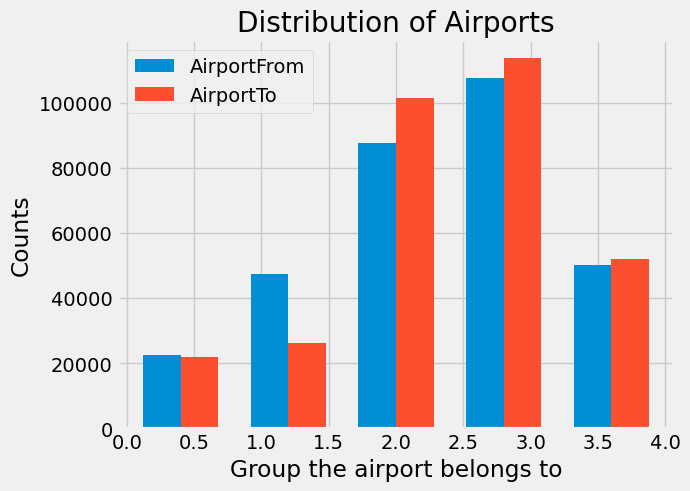

In [17]:
# Check the distribution of groups of airports
num_bins = 5
entries, bin_edges, patches = plt.hist([data["AirportFrom"], data["AirportTo"]], 
                                       bins=num_bins,
                                       rwidth=0.7, density=False, 
                                       label=["AirportFrom", "AirportTo"])

#plt.xlabel('Groups of frequent-departing airports')
#plt.ylabel('Counts')
plt.legend(loc="upper left")
plt.xlabel('Group the airport belongs to')
plt.ylabel('Counts')
plt.title('Distribution of Airports')
plt.show()

### Dummies for "AirportFrom"

In [18]:
data = create_dummies("AirportFrom", data)
data

,Time,Length,AirportTo,DayOfWeek,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,Class
0,1296.0,141.0,3,1,0,0,0,0,0,0,0
1,360.0,146.0,1,4,1,0,0,0,0,1,0
2,1170.0,143.0,2,3,0,1,0,1,0,0,0
3,1410.0,344.0,2,6,0,0,0,0,0,1,0
4,692.0,98.0,0,4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
539371,1170.0,86.0,4,1,0,0,1,0,0,0,1
539373,1240.0,154.0,2,7,0,0,0,0,1,0,1
539375,480.0,287.0,2,2,0,0,0,1,0,0,1
539377,530.0,72.0,3,5,1,0,0,0,0,1,1


### Dummies for "AirportTo"

In [19]:
data = create_dummies("AirportTo", data)
data

,Time,Length,DayOfWeek,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_2,AirportTo_3,AirportTo_4,Class
0,1296.0,141.0,1,0,0,0,0,0,0,0,0,1,0,0
1,360.0,146.0,4,1,0,0,0,0,1,1,0,0,0,0
2,1170.0,143.0,3,0,1,0,1,0,0,0,1,0,0,0
3,1410.0,344.0,6,0,0,0,0,0,1,0,1,0,0,0
4,692.0,98.0,4,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539371,1170.0,86.0,1,0,0,1,0,0,0,0,0,0,1,1
539373,1240.0,154.0,7,0,0,0,0,1,0,0,1,0,0,1
539375,480.0,287.0,2,0,0,0,1,0,0,0,1,0,0,1
539377,530.0,72.0,5,1,0,0,0,0,1,0,0,1,0,1


### Length

In [20]:
a = data["Length"].min()
b = data["Length"].max()
print(a, b)

0.0 655.0


Text(0.5, 1.0, "Distribution of flight's length")

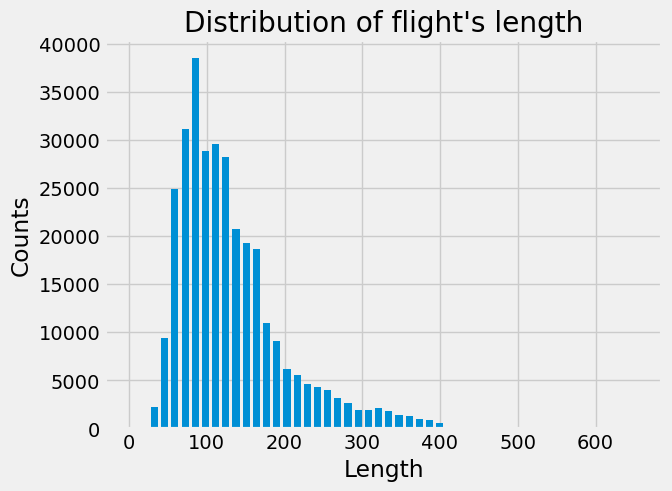

In [21]:
# checking the distribution of length 
num_bins = 50
entries, bin_edges, patches = plt.hist(data["Length"], 
                                       bins=num_bins, rwidth=0.7, density=False
                                      )

plt.xlabel('Length')
plt.ylabel('Counts')
plt.title('Distribution of flight\'s length')

### Time

In the Time column, time is given in minutes after midnight. For example: 1296 → 21:36h. Let us point out that this time is the time of take-off of a plane, and not the time that a plane was in the air.

In [22]:
a = data["Time"].min()
b = data["Time"].max()
print(a, b)

10.0 1439.0


Text(0.5, 1.0, 'Distribution of time')

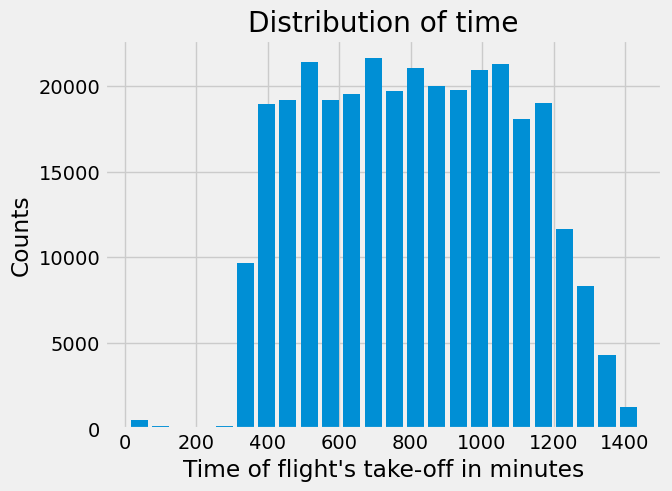

In [23]:
# Checking the distribution of time 
num_hours = 24
entries, bin_edges, patches = plt.hist(data["Time"], 
                                       bins=num_hours, rwidth=0.8, density=False
                                      )

plt.xlabel("Time of flight\'s take-off in minutes")
plt.ylabel('Counts')
plt.title('Distribution of time')

The "Time" column can be treated as a cathegorical variable. We will create a model where we will check dependence of the output on the part of a day and divide a day into 4 parts: night, morning, afternoon, evening:

- night: 0 - 359, (00:00 - 05:59) - 0
- morning: 360 - 719, (06:00 - 11:59) - 1
- afternoon: 720 - 1079 (12:00 - 17:59) - 2
- evening: 1080 - 1440 (18:00 - 23:59) - 3

In [24]:
data['Time']

0         1296.0
1          360.0
2         1170.0
3         1410.0
4          692.0
           ...  
539371    1170.0
539373    1240.0
539375     480.0
539377     530.0
539379     827.0
Name: Time, Length: 315753, dtype: float64

In [25]:
# Create a function to group the start time of a flight
def group_time(time):

    timelist = []
    for value in time.values:
        if 0<=value<=359:
            timelist.append(0)
        elif 360<=value<=719:
            timelist.append(1)
        elif 720<=value<=1079:
            timelist.append(2)
        else:
            timelist.append(3)
        
    return timelist
    
data["Time"] = group_time(data["Time"])

In [26]:
data

,Time,Length,DayOfWeek,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_2,AirportTo_3,AirportTo_4,Class
0,3,141.0,1,0,0,0,0,0,0,0,0,1,0,0
1,1,146.0,4,1,0,0,0,0,1,1,0,0,0,0
2,3,143.0,3,0,1,0,1,0,0,0,1,0,0,0
3,3,344.0,6,0,0,0,0,0,1,0,1,0,0,0
4,1,98.0,4,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539371,3,86.0,1,0,0,1,0,0,0,0,0,0,1,1
539373,3,154.0,7,0,0,0,0,1,0,0,1,0,0,1
539375,1,287.0,2,0,0,0,1,0,0,0,1,0,0,1
539377,1,72.0,5,1,0,0,0,0,1,0,0,1,0,1


### Dummies for Time

In [27]:
data = create_dummies("Time", data)
data

,Length,DayOfWeek,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_2,AirportTo_3,AirportTo_4,Time_1,Time_2,Time_3,Class
0,141.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,146.0,4,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,143.0,3,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,344.0,6,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,98.0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539371,86.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1
539373,154.0,7,0,0,0,0,1,0,0,1,0,0,0,0,1,1
539375,287.0,2,0,0,0,1,0,0,0,1,0,0,1,0,0,1
539377,72.0,5,1,0,0,0,0,1,0,0,1,0,1,0,0,1


### DayOfWeek

In [28]:
data["DayOfWeek"].unique()

array([1, 4, 3, 6, 7, 2, 5])

Text(0.5, 1.0, 'Distribution of DayOfWeek')

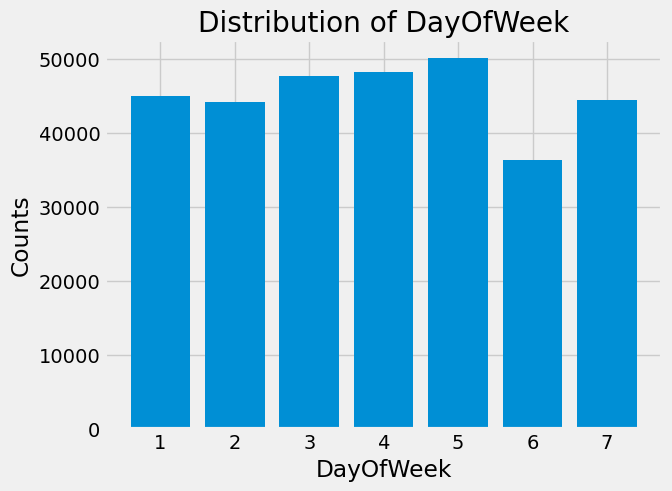

In [29]:
# Check the distribution of time 
entries, bin_edges, patches = plt.hist(data["DayOfWeek"], 
                                       bins=np.arange(0.5, 8.5), rwidth=0.8, density=False
                                      )

plt.xlabel('DayOfWeek')
plt.ylabel('Counts')
plt.title('Distribution of DayOfWeek')

### Dummies for "DayOfWeek"

In [30]:
# Group DayOfWeek into three types: beginning of the week (0), middle of week (1), weekend (2)
day_dict = {1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2}

data["DayOfWeek"] = data["DayOfWeek"].map(day_dict)
data

,Length,DayOfWeek,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_2,AirportTo_3,AirportTo_4,Time_1,Time_2,Time_3,Class
0,141.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,146.0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,143.0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,344.0,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,98.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539371,86.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
539373,154.0,2,0,0,0,0,1,0,0,1,0,0,0,0,1,1
539375,287.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
539377,72.0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1


In [31]:
data = create_dummies("DayOfWeek", data)
data

,Length,Airline_1,Airline_2,AirportFrom_1,AirportFrom_2,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_2,AirportTo_3,AirportTo_4,Time_1,Time_2,Time_3,DayOfWeek_1,DayOfWeek_2,Class
0,141.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,146.0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0
2,143.0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0
3,344.0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
4,98.0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539371,86.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
539373,154.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1
539375,287.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
539377,72.0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1


### Check correlations between columns

In [32]:
# Use Pearson correlation coefficient to check correlation between columns
correls = data.corr()

<AxesSubplot:>

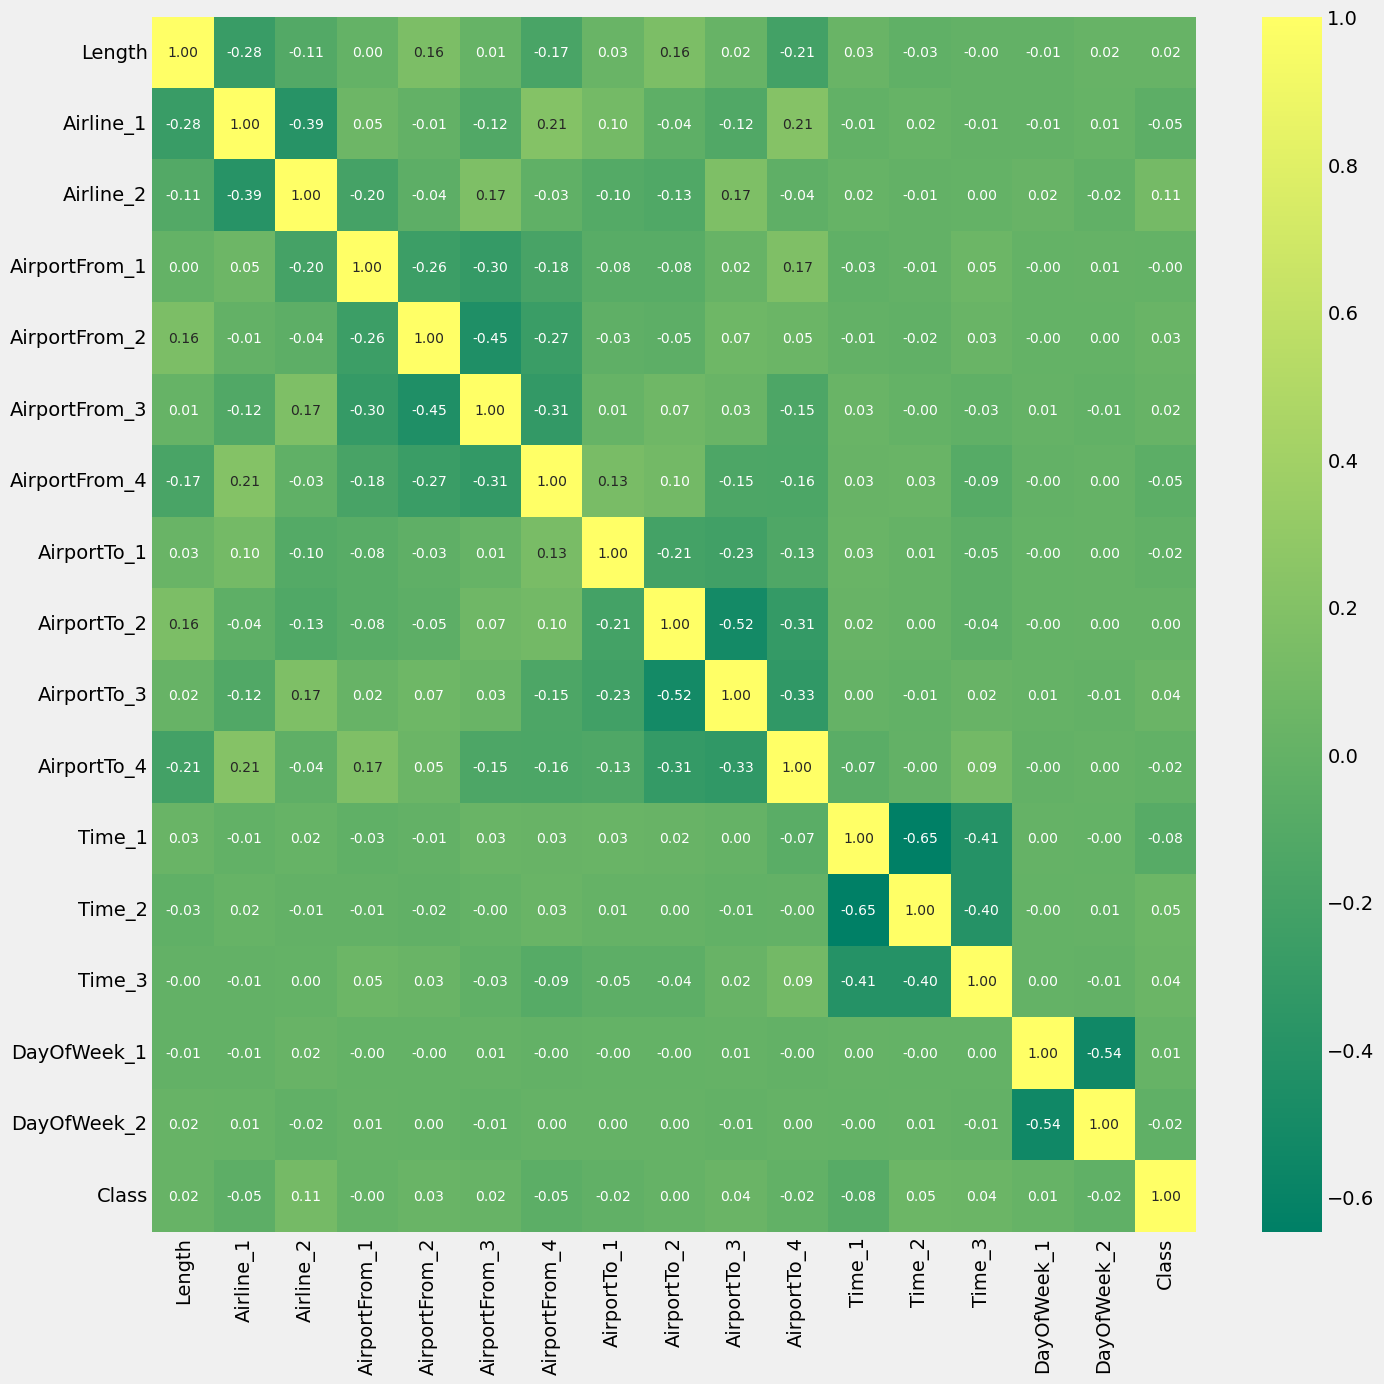

In [33]:
# Show correlation
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, annot_kws={'size':10}, fmt='.2f', cmap='summer')

In [34]:
correls.values
correls.columns.values[0]

'Length'

In [35]:
# Find overcorrelated columns, where \r\>=0.4
list_col = []
for i in range(len(correls.values)):
    for j in range (len(correls.index)):
        if ((-1< correls.values[i][j] <=-0.4) or (0.4 <= correls.values[i][j] <1)) and i<j:
            #data.drop([data.iloc[:,i]], axis=1, inplace=True)
            list_col.append(correls.columns.values[i])
    
# Remove duplicates from the list of overcorrelated columns
corr_col = [*set(list_col)]
corr_col 

['Time_2', 'AirportFrom_2', 'DayOfWeek_1', 'Time_1', 'AirportTo_2']

In [36]:
# Remove columns with large correlation
data.drop(corr_col, axis=1, inplace=True)

<AxesSubplot:>

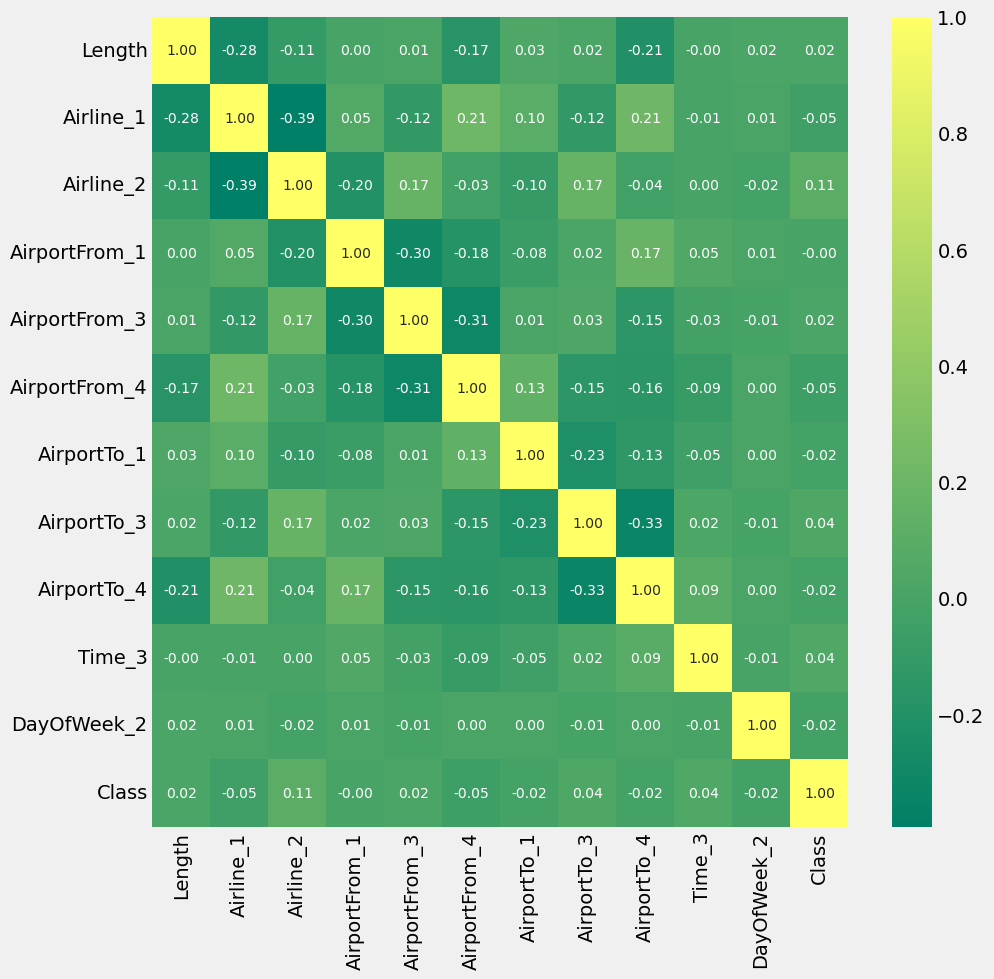

In [37]:
# Check Pearson correlation between columns again
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, annot_kws={'size':10}, fmt='.2f', cmap='summer')

In [38]:
data_preprocessed = data.copy()

## Select inputs and targets

In [39]:
targets = data["Class"]
inputs = data.iloc[:,:-1]

## Select dummies

In [40]:
# Define a function to select columns with dummies
def select_dummies(data):
    
    col_dummies = []
    for column in data.columns:
        vc = data[column].value_counts()
        comp = vc.values.tolist()
        s = data[column].sum()
        
        # Compare the number of 1s in the column to the sum of all values
        if comp[1] == s:
            col_dummies.append(column)
        
    return col_dummies

In [41]:
columns_with_dummies = select_dummies(inputs)
columns_with_dummies

['Airline_1',
 'Airline_2',
 'AirportFrom_1',
 'AirportFrom_3',
 'AirportFrom_4',
 'AirportTo_1',
 'AirportTo_3',
 'AirportTo_4',
 'Time_3',
 'DayOfWeek_2']

In [42]:
columns_without_dummies = inputs.drop(columns_with_dummies, axis=1)
columns_without_dummies

,Length
0,141.0
1,146.0
2,143.0
3,344.0
4,98.0
...,...
539371,86.0
539373,154.0
539375,287.0
539377,72.0


## Select outliers

In [43]:
# Define function to find outliers and calculate the percentage of them in each column
def evaluate_outliers(data):
    
    outliers_percents = {}
    for column in data.columns:
        if data[column].dtype!=object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5*iqr)
            lower_bound = q1 - (1.5*iqr)
            outliers = data[(data[column]>upper_bound) | (data[column]<lower_bound)][column]
            outliers_percentage = len(outliers)/len(data[column])*100
            outliers_percents[column] = outliers_percentage
            outliers_dataframe = pd.DataFrame(data=outliers_percents.values(), 
                                             index=outliers_percents.keys(), 
                                             columns=['Outlier percentage']
                                             )
    
    return outliers_dataframe.sort_values(by='Outlier percentage', ascending=False)

In [44]:
df_no_dummies = evaluate_outliers(columns_without_dummies)
df_no_dummies

,Outlier percentage
Length,4.927903


In [45]:
#Define function which select columns with outliers
def select_outliers(data):
    
    outliers = []
    for column in data.columns:
        for i in range(len(data)):
            k = data[column].index.tolist()
            if data[column][i]>0.0:
                outliers.append(k[i])
                
    return outliers

In [46]:
columns_with_outliers = select_outliers(df_no_dummies)
columns_with_outliers

['Length']

In [47]:
inputs.columns.values

array(['Length', 'Airline_1', 'Airline_2', 'AirportFrom_1',
       'AirportFrom_3', 'AirportFrom_4', 'AirportTo_1', 'AirportTo_3',
       'AirportTo_4', 'Time_3', 'DayOfWeek_2'], dtype=object)

In [48]:
columns_without_outliers = [x for x in inputs.columns.values if 
                            (x not in columns_with_dummies and 
                             x not in columns_with_outliers)
                           ]

columns_without_outliers

[]

In [49]:
inputs.reset_index(inplace=True, drop=True)
inputs

,Length,Airline_1,Airline_2,AirportFrom_1,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_3,AirportTo_4,Time_3,DayOfWeek_2
0,141.0,0,0,0,0,0,0,1,0,1,0
1,146.0,1,0,0,0,1,1,0,0,0,0
2,143.0,0,1,0,0,0,0,0,0,1,0
3,344.0,0,0,0,0,1,0,0,0,1,1
4,98.0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
315748,86.0,0,0,1,0,0,0,0,1,1,0
315749,154.0,0,0,0,1,0,0,0,0,1,1
315750,287.0,0,0,0,0,0,0,0,0,0,0
315751,72.0,1,0,0,0,1,0,1,0,0,0


## Standardize data

In general, one can have three types of data:
- dummies
- data without outliers
- data with outliers

Dummies do not have to be standardized, but the other two groups have to be standardized. We create two types of scalers to standardize the two groups. These scalers are of the general use.

### Declare instances of scalers and apply them

In [50]:
# Load the newly created module for scalers
from scalers import *

In [51]:
try:
    flights_scaler_standard = CustomScalerStandard(columns_without_outliers)
    flights_scaler_standard.fit(inputs)
    inputs = flights_scaler_standard.transform(inputs)  
except:
    print("No columns without outliers.")

inputs

No columns without outliers.


,Length,Airline_1,Airline_2,AirportFrom_1,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_3,AirportTo_4,Time_3,DayOfWeek_2
0,141.0,0,0,0,0,0,0,1,0,1,0
1,146.0,1,0,0,0,1,1,0,0,0,0
2,143.0,0,1,0,0,0,0,0,0,1,0
3,344.0,0,0,0,0,1,0,0,0,1,1
4,98.0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
315748,86.0,0,0,1,0,0,0,0,1,1,0
315749,154.0,0,0,0,1,0,0,0,0,1,1
315750,287.0,0,0,0,0,0,0,0,0,0,0
315751,72.0,1,0,0,0,1,0,1,0,0,0


In [52]:
try:
    flights_scaler_robust = CustomScalerRobust(columns_with_outliers)
    flights_scaler_robust.fit(inputs)
    inputs = flights_scaler_robust.transform(inputs)
except:
    print("No columns with outliers.")
    
inputs

,Length,Airline_1,Airline_2,AirportFrom_1,AirportFrom_3,AirportFrom_4,AirportTo_1,AirportTo_3,AirportTo_4,Time_3,DayOfWeek_2
0,0.329114,0,0,0,0,0,0,1,0,1,0
1,0.392405,1,0,0,0,1,1,0,0,0,0
2,0.354430,0,1,0,0,0,0,0,0,1,0
3,2.898734,0,0,0,0,1,0,0,0,1,1
4,-0.215190,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
315748,-0.367089,0,0,1,0,0,0,0,1,1,0
315749,0.493671,0,0,0,1,0,0,0,0,1,1
315750,2.177215,0,0,0,0,0,0,0,0,0,0
315751,-0.544304,1,0,0,0,1,0,1,0,0,0


## Check multicollinearity

In [53]:
# Check VIF after standarization
# Import vif method from models of statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define functions that we want to check for multiple collinearity
# This part is a part of syntax of vif
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(inputs.values, i) for i in range(inputs.shape[1])]
vif["features"] = inputs.columns

vif

,VIF,features
0,1.128296,Length
1,1.782474,Airline_1
2,1.769521,Airline_2
3,1.281613,AirportFrom_1
4,1.547971,AirportFrom_3
5,1.381726,AirportFrom_4
6,1.171398,AirportTo_1
7,1.671857,AirportTo_3
8,1.514168,AirportTo_4
9,1.231923,Time_3


We accept VIF < 5, so no high multicollinearity in this case.

## Features selection

In [54]:
# Import an algorithm to select the best set of features
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [55]:
# Fit and transform the data to select best features
col_names = inputs.columns.values

sel_feat = SelectKBest(f_classif, k=10)

inp = sel_feat.fit_transform(inputs, targets)

# Choose proper names of columns by taking their index
ind = sel_feat.get_support(indices=True)
features_new = col_names[ind]

# Create a new dataset for inputs with selected columns only
inputs = pd.DataFrame(inp, columns=features_new)

A relatively large number of columns is left (as compared to the original number), to leave enough data for training. It was checked that the metrics after training the model become worse if we decrease too much the number of features. 

If the number of columns was much higher, the efficiency of feature selection could work better.

## Save inputs and targets without further instances cleaning for experiment

In [56]:
# Before saviong, check the types of all columns
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315753 entries, 0 to 315752
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Length         315753 non-null  float64
 1   Airline_1      315753 non-null  float64
 2   Airline_2      315753 non-null  float64
 3   AirportFrom_3  315753 non-null  float64
 4   AirportFrom_4  315753 non-null  float64
 5   AirportTo_1    315753 non-null  float64
 6   AirportTo_3    315753 non-null  float64
 7   AirportTo_4    315753 non-null  float64
 8   Time_3         315753 non-null  float64
 9   DayOfWeek_2    315753 non-null  float64
dtypes: float64(10)
memory usage: 24.1 MB


In [57]:
targets.info()

<class 'pandas.core.series.Series'>
Int64Index: 315753 entries, 0 to 539379
Series name: Class
Non-Null Count   Dtype
--------------   -----
315753 non-null  int64
dtypes: int64(1)
memory usage: 4.8 MB


In [58]:
# Change the types of the label and all dummies to categorical
# This will allow estimators to recognize categorical varibales, and also save some memory

# Use CategoricalDtype to allow for ordered=True, then some mathematical operations are possible 
from pandas.api.types import CategoricalDtype

targets = targets.astype(CategoricalDtype(ordered=True))

new_col_with_dummies = select_dummies(inputs)
inputs[new_col_with_dummies] = inputs[new_col_with_dummies].astype(CategoricalDtype(ordered=True))

inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315753 entries, 0 to 315752
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Length         315753 non-null  float64 
 1   Airline_1      315753 non-null  category
 2   Airline_2      315753 non-null  category
 3   AirportFrom_3  315753 non-null  category
 4   AirportFrom_4  315753 non-null  category
 5   AirportTo_1    315753 non-null  category
 6   AirportTo_3    315753 non-null  category
 7   AirportTo_4    315753 non-null  category
 8   Time_3         315753 non-null  category
 9   DayOfWeek_2    315753 non-null  category
dtypes: category(9), float64(1)
memory usage: 5.1 MB


We save the inputs and targets at this step of preprocessing to see at later stages the comparison of models performance with and without instances selection.

In [59]:
inputs.to_csv("src/inputs_exp.csv", index=False)
targets.to_csv("src/targets_exp.csv", index=False)

In [60]:
# Check the imbalance parameter, which can be needed for training the model to set weights of classes
(targets.shape[0]-targets.value_counts()[1])/targets.value_counts()[1]

1.09038728897716

## Instances selection

This is the key ingredient to make the data well distributed and to remove the oversampled rows which introduce a lot of noise. After ckecking many different methods, the combination of EditedNearestNeighbours and InstanceHarnessThreshold works best for this dataset.

In [61]:
# Load libraries to eliminate the noise row-wise
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import InstanceHardnessThreshold

from imblearn.pipeline import Pipeline

In [62]:
# Make pipeline to step-by-step eliminate the instances/rows which introduce too much noise to data

enn = EditedNearestNeighbours(n_neighbors=5)
iht = InstanceHardnessThreshold(random_state=45)

pipe = Pipeline([('enn', enn), ('iht', iht)])

inputs_a, targets_a = pipe.fit_resample(inputs, targets)

In [64]:
# Check the imbalance parameter, which can be needed for training the model to set weights of classes
(targets.shape[0]-targets.value_counts()[1])/targets.value_counts()[1]

1.09038728897716

In [65]:
inputs_a.shape

(153660, 10)

In [66]:
targets_a.shape

(153660,)

## Save inputs and targets

In [63]:
inputs_a.to_csv("src/inputs.csv", index=False)
targets_a.to_csv("src/targets.csv", index=False)